# Problem

**10×10 Gridworld**

**Layout (row-major indices)**

Legend: **S** start, **G** goal (terminal), **P** pit (terminal), **#** wall, **.** empty

```
r\c  0 1 2 3 4 5 6 7 8 9
0    S . . . # . . . . .
1    . # . . # . . # P .
2    . # # . . . . # . .
3    . . P . # . . # . .
4    # . # # # # # # . #
5    . . . . # . . P . .
6    . P # . # . # . . .
7    . . # . . P # . . .
8    . . # . # . # # P .
9    . . . . # . . . . G
```

**State space**

$$
\mathcal{X}={0,1,\dots,99},\quad x=10r+c
$$

* **Goal (absorbing):** $x_G=99$
* **Pits (absorbing):**
  $
  \mathcal{X}_{\text{pit}}={18,32,57,61,75,88}
  $
* **Walls (impassable):**
  $
  \mathcal{X}_{\text{wall}}={4,11,14,17,21,22,27,34,37,40,42,43,44,45,46,47,49,54,62,64,66,72,76,82,84,86,87,94}
  $

Terminal set:
$
\mathcal{T}={99}\cup \mathcal{X}_{\text{pit}}
$

**Action space**

$$
\mathcal{A}={0,1,2,3}
$$
where (0=) Up, (1=) Down, (2=) Left, (3=) Right.

**Transition dynamics (deterministic)**

Let $x\mapsto(r,c)$ by $r=\lfloor x/10\rfloor,\ c=x\bmod 10$.

* If $x\in\mathcal{T}$, then $\text{next\_state}(x,a)=x$ $absorbing$.
* Otherwise, compute the intended neighbor $(r',c')$ from action $a$.
* If $(r',c')$ is outside the grid, **stay**.
* Let $x'=10r'+c'$. If $x'\in\mathcal{X}_{\text{wall}}$, **stay**.

Transition matrix shape:
$$
P\in\mathbb{R}^{(|\mathcal{X}||\mathcal{A}|)\times|\mathcal{X}|}=\mathbb{R}^{400\times 100},
$$
with
$$
P[(x,a),x']=1 \iff x'=\text{next\_state}(x,a)
$$

**Reward model (standard step cost + terminal outcomes)**

Reward based on the **next state**:
$$
r(x,a)=
\begin{cases}
+1 & \text{if } \text{next\_state}(x,a)=99,\
-5 & \text{if } \text{next\_state}(x,a)\in \mathcal{X}_{\text{pit}},\
-0.1 & \text{otherwise.}
\end{cases}
$$

**Initial state**

$$
x_0=0.
$$

In [63]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
# Add project root to the Python path
sys.path.append(str(PROJECT_ROOT))
# Define dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "10grid_wall.csv"
DATASET_PATH_OPT = PROJECT_ROOT / "datasets" / "10grid_wall_opt.csv"

from fogas import FOGASSolverVectorized, FOGASOracleSolverVectorized, FOGASHyperOptimizer, FOGASEvaluator, PolicySolver, EnvDataCollector, DatasetAnalyzer

seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tabular Features

In [2]:
# ===== 10x10 Four-Rooms Grid (harder) =====

states  = np.arange(100)
actions = np.arange(4)
N = len(states)     # 100
A = len(actions)    # 4
gamma = 0.9

x_0 = 0  # fixed initial state

goal = 99  # absorbing terminal state

# pits (absorbing terminal states)
pits = {18, 32, 57, 61, 75, 88}

# walls (impassable)
walls = {
    4, 11, 14, 17, 21, 22, 27, 34, 37,
    40, 42, 43, 44, 45, 46, 47, 49,
    54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94
}

# ---------- Tabular features ----------
def phi(x, a):
    vec = np.zeros(N * A)
    vec[x * A + a] = 1.0
    return vec

# ---------- Reward weights (tabular) ----------
step_cost = -0.1
goal_reward = 1.0
pit_reward  = -5.0

omega = np.full(N * A, step_cost)

# override terminal rewards (all actions in terminal states)
omega[goal * A : goal * A + A] = goal_reward
for p in pits:
    omega[p * A : p * A + A] = pit_reward

# ---------- Helpers: index <-> (row, col) ----------
def to_rc(s):  return divmod(s, 10)
def to_s(r, c): return r * 10 + c

# ---------- Dynamics ----------
def next_state(s, a):
    # absorbing terminals
    if s == goal or s in pits:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r - 1), c
    elif a == 1:    # Down
        r2, c2 = min(9, r + 1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c - 1)
    elif a == 3:    # Right
        r2, c2 = r, min(9, c + 1)
    else:
        raise ValueError("Invalid action")

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp in walls:
        return s

    return sp

# ---------- Backward feature map psi(x') ----------
def psi(xp):
    v = np.zeros(N * A)
    for x in states:
        for a in actions:
            if next_state(x, a) == xp:
                v[x * A + a] = 1.0
    return v

# ---------- Build solver ----------
mdp = PolicySolver(
    states=states,
    actions=actions,
    phi=phi,
    omega=omega,
    gamma=gamma,
    x0=x_0,
    psi=psi
)


### Oracle

In [3]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1000
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             100
Num actions A:            4
Feature dim d:            400
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      9255128.526390366
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000263
rho:                            66.292053
eta:                            0.000002
D_theta:                    63.245553
beta (ridge):             0.000003
D_pi (derived):           16.651092





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = 0.1000
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.5147e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = 0.0926

Optimizing rho
[After rho*] alpha=4.5147e+00, rho=1.7321e-01, eta=1.0000e-02 | metric = 0.0722

Optimizing eta
[After eta*] alpha=4.5147e+00, rho=1.7321e-01, eta=1.4277e-02 | metric = 0.0690


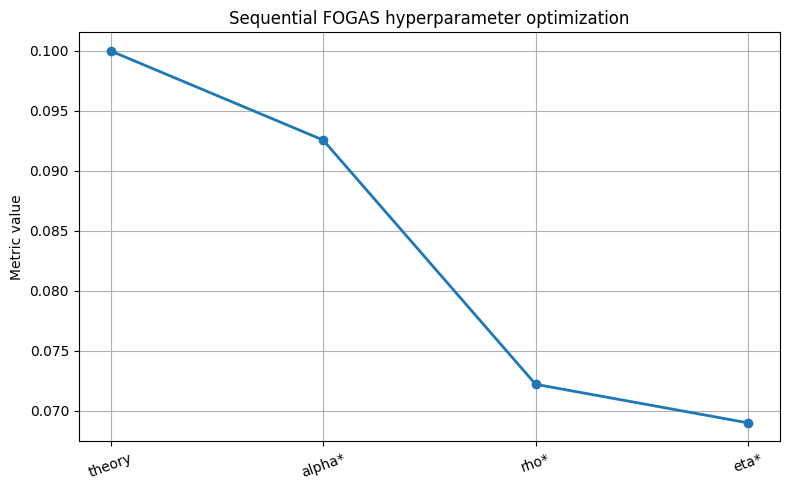

In [4]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=7,
    print_main=True, 
    num_runs=1,
    random_candidates=10,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [ ]:
solver.run(T = 10000, alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)

FOGAS Oracle: 100%|██████████| 10000/10000 [02:29<00:00, 66.73it/s]



  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 1       │ Reward:  -0.100 │ → 10
  Step   1 │ State: 10       │ Action: 3       │ Reward:  -0.100 │ → 10 ⚠️ SELF-LOOP!

  ──────────────────────────────────────────────────────────────────
  Trajectory Length: 2 steps
  Discounted Return: -0.190000
  Final State: 10

----------------------------------------------------------------------
  Expected Return (from V): -0.082549
  Optimal Return (π*): -0.012257
  Gap (J* - J): 7.029253e-02



  STATE POLICY DIAGNOSTICS - Learned Policy (π_FOGAS)

Inspecting State: 10
Value V(s=10): -1.000000

Policy Probabilities:
  π(a=0|s=10) = 0.0000 ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
  π(a=1|s=10) = 0.4167 ████████████░░░░░░░░░░░░░░░░░░
  π(a=2|s=10) = 0.2916 ████████░░░░░░░░░░░░░░░░░░░░░░
  π(a=3|s=10) = 0.2916 ████████░░░░░░░░░░░░░░░░░░░░░░

Actio

In [16]:
evaluator.print_optimal_path()


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 1       │ Reward:  -0.100 │ → 12
  Step   3 │ State: 12       │ Action: 3       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 0       │ Reward:  -0.100 │ → 5
  Step   9 │ State: 5        │ Action: 3       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7        │ Action: 3

### Dataset Collection

In [ ]:
collector = EnvDataCollector(mdp=mdp, env_name="10grid_wall_opt", max_steps=50)

# Collect mixed dataset: 50% random, 50% optimal
collector.collect_mixed_dataset(
    policies=["random", mdp.pi_star],  # List of policies
    proportions=[0.9, 0.1],            # 50-50 split
    n_steps=3000,
    episode_based=True,                # Entire episodes use one policy
    save_path=str(DATASET_PATH_OPT),
    verbose=True
)


  MIXED DATASET COLLECTION SUMMARY
Total transitions: 3000
Total episodes: 48
Mode: Episode-based

Policy Distribution:
  Policy 0:  2888 steps (96.3%) | Target: 90.0% | Episodes: 44
  Policy 1:   112 steps ( 3.7%) | Target: 10.0% | Episodes: 5

✅ Mixed dataset saved to: /home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/10grid_wall_opt.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,0,-0.1,0,0
1,0,1,0,1,-0.1,10,0
2,0,2,10,1,-0.1,20,0
3,0,3,20,2,-0.1,20,0
4,0,4,20,0,-0.1,10,0
...,...,...,...,...,...,...,...
2995,48,11,7,3,-0.1,8,1
2996,48,12,8,3,-0.1,9,1
2997,48,13,9,1,-0.1,19,1
2998,48,14,19,1,-0.1,29,1


In [64]:
analyzer = DatasetAnalyzer(DATASET_PATH_OPT)
analyzer.summary()

Dataset Analysis Summary
Source: /home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/10grid_wall_opt.csv
Total transitions: 3,000
Unique (state, action) pairs: 115
Unique states visited: 39
Unique actions taken: 4
--------------------------------------------------
Pair Frequency Statistics:
  Min count:    1
  Max count:    115
  Mean count:   26.09
  Std count:    27.33
  Median count: 13.0


In [66]:
analyzer.analyze_state(24)

Analysis for State 24
Total visits to this state: 76
Actions seen: 4, Missing: 0
State mean count: 19.00 (Global mean: 26.09)
Avg diff from global mean: -7.09
------------------------------------------------------------
Per-Action Breakdown:
------------------------------------------------------------
  Action  0: count=  18, diff=   -8.1, z=-0.30 
  Action  1: count=  18, diff=   -8.1, z=-0.30 
  Action  2: count=  13, diff=  -13.1, z=-0.48 
  Action  3: count=  27, diff=   +0.9, z=+0.03 


{'state_stats': {'state': 24,
  'total_visits': 76,
  'n_actions_seen': 4,
  'n_actions_missing': 0,
  'state_mean': 19.0,
  'state_std': 5.049752469181039,
  'min_action_count': 13,
  'max_action_count': 27,
  'global_mean': 26.08695652173913,
  'avg_diff_from_global': -7.086956521739129},
 'action_details':    state  action  count  diff_from_mean  ratio_to_mean   z_score
 0     24       0     18       -8.086957       0.690000 -0.295883
 1     24       1     18       -8.086957       0.690000 -0.295883
 2     24       2     13      -13.086957       0.498333 -0.478821
 3     24       3     27        0.913043       1.035000  0.033406}

In [34]:
collector = EnvDataCollector(mdp=mdp, env_name="10grid_wall", max_steps=100)
collector.collect_dataset(n_steps=2000, save_path=str(DATASET_PATH), verbose=True)

✅ Dataset saved to: /home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/10grid_wall.csv
   Total transitions: 2000


,episode,step,state,action,reward,next_state
0,0,0,0,1,-0.1,10
1,0,1,10,2,-0.1,10
2,0,2,10,3,-0.1,10
3,0,3,10,0,-0.1,0
4,0,4,0,3,-0.1,1
...,...,...,...,...,...,...
1995,28,24,3,0,-0.1,3
1996,28,25,3,1,-0.1,13
1997,28,26,13,2,-0.1,12
1998,28,27,12,0,-0.1,2


### Empirical

In [17]:
solver_e = FOGASSolverVectorized(
    mdp=mdp, 
    print_params=True, 
    csv_path=str(DATASET_PATH),
    T=1000)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           2000
Feature norm bound R:     1.0000
Num states N:             100
Num actions A:            4
Feature dim d:            400
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      1851.0257052780732
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000263
rho:                            4687.556056
eta:                            0.000002
D_theta:                    63.245553
beta (ridge):             0.000003
D_pi (derived):           16.651092




In [24]:
# Simple grid search on alpha from 1 to 5 with 10 points
# Fix eta=0.02 and rho=0.05
alpha_star_e, grid_values, metric_values = optimizer_e.simple_grid_search(
    param_name="alpha",
    bounds=(0.1, 5.0),
    n_points=15,
    fixed_params={"eta": 0.02, "rho": 0.05},
    log_scale=True,  # Linear spacing
    num_runs=1,
    print_results=True)

# Use the fixed values
rho_star_e = 0.05
eta_star_e = 0.02

Point 1/15: eta=0.02, rho=0.05, alpha=0.1 → metric=0.402485
Point 2/15: eta=0.02, rho=0.05, alpha=0.1322 → metric=1.271310
Point 3/15: eta=0.02, rho=0.05, alpha=0.1749 → metric=1.201016
Point 4/15: eta=0.02, rho=0.05, alpha=0.2312 → metric=1.305609
Point 5/15: eta=0.02, rho=0.05, alpha=0.3058 → metric=1.696292
Point 6/15: eta=0.02, rho=0.05, alpha=0.4044 → metric=1.371448
Point 7/15: eta=0.02, rho=0.05, alpha=0.5347 → metric=2.279367
Point 8/15: eta=0.02, rho=0.05, alpha=0.7071 → metric=0.100035
Point 9/15: eta=0.02, rho=0.05, alpha=0.9351 → metric=1.542743
Point 10/15: eta=0.02, rho=0.05, alpha=1.237 → metric=0.126201
Point 11/15: eta=0.02, rho=0.05, alpha=1.635 → metric=0.100041
Point 12/15: eta=0.02, rho=0.05, alpha=2.162 → metric=0.100164
Point 13/15: eta=0.02, rho=0.05, alpha=2.859 → metric=0.100000
Point 14/15: eta=0.02, rho=0.05, alpha=3.781 → metric=0.100000
Point 15/15: eta=0.02, rho=0.05, alpha=5 → metric=0.100000

✅ Best alpha = 3.781072 with metric = 0.100000


In [35]:
# Run solver with best alpha and fixed rho, eta
solver_e.run(alpha=alpha_star_e, eta=eta_star_e, rho=rho_star_e, tqdm_print=True, T=2000)
evaluator_e.print_policy()

FOGAS:   0%|          | 0/2000 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 2000/2000 [00:35<00:00, 56.95it/s]

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 0.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 1.00  --> best action: 3
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.00  π(a=2|s=2) = 0.00  π(a=3|s=2) = 1.00  --> best action: 3
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 1.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 0.00  --> best action: 1
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 1.00  π(a=3|s=6) = 0.00  --> best action: 2
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 1.00  π(a=3|s=7) = 0.00  --> best action: 2
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 0.00  π(a=2|s=8) = 0.50  π(a=3|s=8) = 0.50  --> best action: 2
  State 9: π(a=0|s=9) = 0.25  π(a=1|s=9) = 0.2

In [51]:
evaluator_e.print_optimal_path(goal_state=99)


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 3       │ Reward:  -0.100 │ → 3
  Step   3 │ State: 3        │ Action: 1       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 2       │ Reward:  -0.100 │ → 24
  Step   8 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   9 │ State: 25       │ Action: 2       │ Reward:  -0.100 │ → 24
  Step  10 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step  11 │ State: 25 

Now with the dataset with the optimal policy

With a full only optimal dataset is not clear (state 1 sam probability for actions non optimal and 0 probability for optimal action).

In [59]:
solver_e1 = FOGASSolverVectorized(
    mdp=mdp,
    csv_path=str(DATASET_PATH_OPT),
    T=1000)
evaluator_e1 = FOGASEvaluator(solver_e1)
optimizer_e1 = FOGASHyperOptimizer(solver=solver_e1,metric_callable=evaluator_e1.get_metric("reward"), seed=seed)

In [ ]:
# Simple grid search on alpha from 1 to 5 with 10 points
# Fix eta=0.02 and rho=0.05
alpha_star_e1, grid_values, metric_values = optimizer_e1.simple_grid_search(
    param_name="alpha",
    bounds=(1.0, 5.0),
    n_points=10,
    fixed_params={"eta": 0.02, "rho": 0.05},
    log_scale=True,  # Linear spacing
    num_runs=1,
    print_results=True)

# Use the fixed values
rho_star_e1 = 0.005
eta_star_e1 = 0.002

Point 1/10: eta=0.02, rho=0.05, alpha=1 → metric=0.100000
Point 2/10: eta=0.02, rho=0.05, alpha=1.196 → metric=0.949317
Point 3/10: eta=0.02, rho=0.05, alpha=1.43 → metric=0.241138
Point 4/10: eta=0.02, rho=0.05, alpha=1.71 → metric=1.671841
Point 5/10: eta=0.02, rho=0.05, alpha=2.045 → metric=1.608862
Point 6/10: eta=0.02, rho=0.05, alpha=2.445 → metric=1.778150
Point 7/10: eta=0.02, rho=0.05, alpha=2.924 → metric=2.768932
Point 8/10: eta=0.02, rho=0.05, alpha=3.497 → metric=2.008072
Point 9/10: eta=0.02, rho=0.05, alpha=4.181 → metric=2.590964
Point 10/10: eta=0.02, rho=0.05, alpha=5 → metric=2.331541

✅ Best alpha = 1.000000 with metric = 0.100000


In [61]:
# Run solver with best alpha and fixed rho, eta
solver_e1.run(alpha=alpha_star_e1, eta=eta_star_e1, rho=rho_star_e1, tqdm_print=True, T=1000)
evaluator_e1.print_policy()

FOGAS:   0%|          | 1/1000 [00:00<03:46,  4.41it/s]

FOGAS: 100%|██████████| 1000/1000 [02:13<00:00,  7.50it/s]

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 0.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 1.00  --> best action: 3
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.02  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.98  --> best action: 3
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 0.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 1.00  --> best action: 3
  State 6: π(a=0|s=6) = 1.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 0.00  --> best action: 0
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.50  π(a=2|s=7) = 0.50  π(a=3|s=7) = 0.00  --> best action: 1
  State 8: π(a=0|s=8) = 0.50  π(a=1|s=8) = 0.00  π(a=2|s=8) = 0.50  π(a=3|s=8) = 0.00  --> best action: 0
  State 9: π(a=0|s=9) = 0.33  π(a=1|s=9) = 0.0

In [62]:
evaluator_e1.print_optimal_path()


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 3       │ Reward:  -0.100 │ → 3
  Step   3 │ State: 3        │ Action: 1       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 2       │ Reward:  -0.100 │ → 23
  Step   7 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   8 │ State: 24       │ Action: 2       │ Reward:  -0.100 │ → 23
  Step   9 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step  10 │ State: 24       │ Action: 2       │ Reward:  -0.100 │ → 23
  Step  11 │ State: 23       │ Action:

# Funky Features

## Definition

## Testing

In [78]:
# -----------------------------
# Problem definition
# -----------------------------
states = np.arange(9)
actions = np.arange(4)
N = len(states)
A = len(actions)
gamma = 0.9

x_0 = 0

goal = 8   # absorbing terminal state
pit  = 5   # absorbing terminal state
wall = 4   # wall cell

step_cost   = -0.01
goal_reward = 1.0
pit_reward  = -1.0

# -----------------------------
# Helpers: state index <-> (row, col)
# -----------------------------
def to_rc(s):  return divmod(int(s), 3)
def to_s(r,c): return int(r)*3 + int(c)

# -----------------------------
# Deterministic dynamics
# -----------------------------
def next_state(s, a):
    s = int(s); a = int(a)

    # absorbing terminals
    if s == goal or s == pit:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r-1), c
    elif a == 1:    # Down
        r2, c2 = min(2, r+1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c-1)
    elif a == 3:    # Right
        r2, c2 = r, min(2, c+1)
    else:
        raise ValueError("Invalid action")

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp == wall:
        return s

    return sp

# -----------------------------
# Build explicit transition matrix P: shape (N*A, N)
# Row corresponds to (x,a) in row-major order: idx = x*A + a
# -----------------------------
P = np.zeros((N * A, N))
for x in states:
    for a in actions:
        idx = int(x) * A + int(a)
        xp = next_state(x, a)
        P[idx, xp] = 1.0

# -----------------------------
# action features: [1, dr, dc] in R^3
# state features: row_onehot ⊗ col_onehot in R^9 (exact state one-hot)
# phi(x,a) = kron(phi_action(a), phi_state(x)) in R^(3*9)=R^27
# -----------------------------
d_state  = 9
d_action = 3
d_feat   = d_state * d_action  # 27

def phi_state(x):
    r, c = to_rc(x)
    row = np.zeros(3); row[r] = 1.0
    col = np.zeros(3); col[c] = 1.0
    return np.kron(row, col)  # R^9

def phi_action(a):
    a = int(a)
    if a == 0:   dr, dc = -1.0,  0.0  # Up
    elif a == 1: dr, dc =  1.0,  0.0  # Down
    elif a == 2: dr, dc =  0.0, -1.0  # Left
    elif a == 3: dr, dc =  0.0,  1.0  # Right
    else:
        raise ValueError("Invalid action")
    return np.array([1.0, dr, dc])  # R^3

def phi(x, a):
    return np.kron(phi_action(a), phi_state(x))  # R^27

# -----------------------------
# Exact omega for state-only reward:
# r(x,a) = r_state(x) for all actions
# Put r_state into the "bias block" omega[0:9], rest zeros.
# -----------------------------
r_state = np.full(N, step_cost)
r_state[goal] = goal_reward
r_state[pit]  = pit_reward

omega = np.zeros(d_feat)
omega[:d_state] = r_state  # exact

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P)

### Oracle

In [79]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1500
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            27
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      18510257.052780736
T (iterations):                1500   (overridden → 1500)

FOGAS Hyperparameters
---------------------
alpha:                        0.000585
rho:                            4.559519
eta:                            0.000013
D_theta:                    16.431677
beta (ridge):             0.000049
D_pi (derived):           14.420269





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = 0.0647
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.1345e+00, rho=5.0000e+00, eta=1.3013e-05 | metric = -0.6507

Optimizing rho
[After rho*] alpha=4.1345e+00, rho=4.2655e+00, eta=1.3013e-05 | metric = -0.6515

Optimizing eta
[After eta*] alpha=4.1345e+00, rho=4.2655e+00, eta=1.6563e-02 | metric = -0.6527


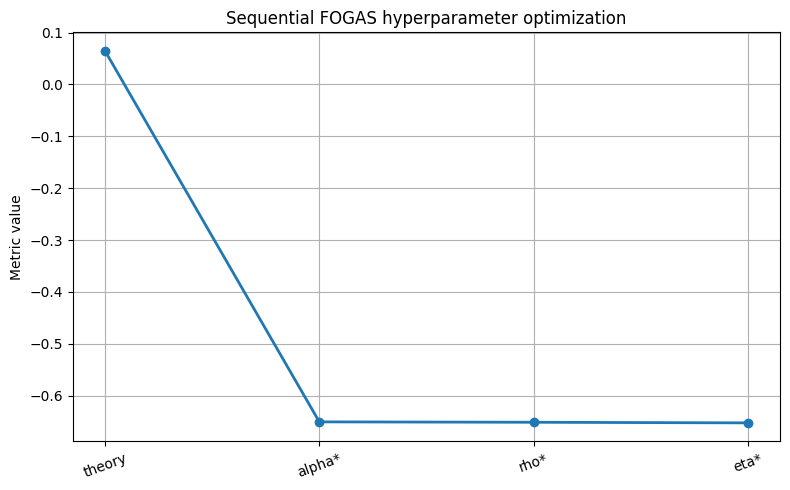

In [80]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [81]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS Oracle:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS Oracle: 100%|██████████| 1500/1500 [00:00<00:00, 7593.05it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526610 | Δ = -8.276947e-09
State 1: V*(x) =  5.863949 | V^π(x) = -8.114815 | Δ = -1.397876e+01
State 2: V*(x) =  5.267554 | V^π(x) = -9.005350 | Δ = -1.427290e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262900 | Δ = -9.149043e-09
State 4: V*(x) =  8.081000 | V^π(x) =  8.081000 | Δ = -2.028674e-09
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.081000 | Δ = -1.016561e-08
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ = -2.254081e-09
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863949 | Δ = -7.449253e-09
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526610 | Δ = -8.234139e-09
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863949 | Δ = -7.449253e-09
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.313334 |

In [82]:
evaluator.print_policy()

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.99  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.01  --> best action: 1
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 1.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 1
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0



### Empirical

In [83]:
solver_e = FOGASSolverVectorized(
    mdp=mdp, 
    print_params=True, 
    csv_path=str(DATASET_PATH
), T=1500)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)


================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           1000
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            27
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      1851.025705278074
T (iterations):                1500   (overridden → 1500)

FOGAS Hyperparameters
---------------------
alpha:                        0.000585
rho:                            455.951925
eta:                            0.000013
D_theta:                    16.431677
beta (ridge):             0.000049
D_pi (derived):           14.420269




In [84]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 2620.02it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |


=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.0118
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527

Optimizing rho
[After rho*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527

Optimizing eta
[After eta*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527


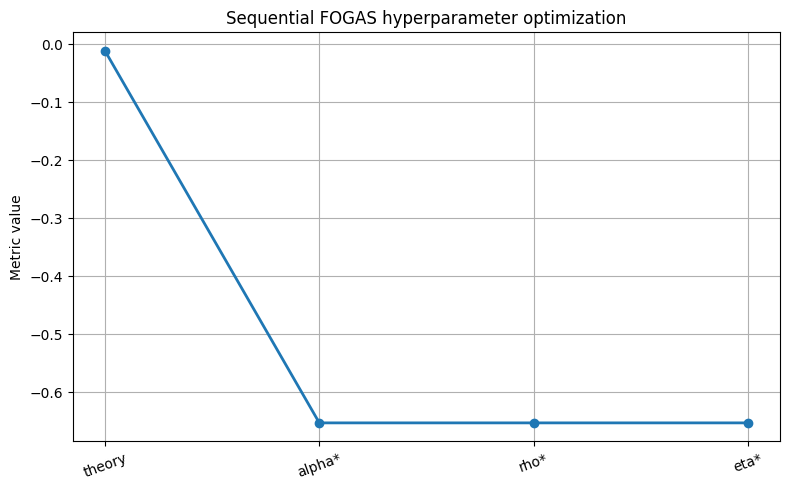

In [86]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=15,
    print_main=True, 
    num_runs=1,
    random_candidates=30,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [89]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 3011.51it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |

In [ ]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 3011.51it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |